In [18]:
import requests
from bs4 import BeautifulSoup as bs
# List of irrelevant terms to exclude while scraping
exclude_terms = ["Main Page", "DOI", "S2CID", "PMID", "ISBN", "ISSN", "identifier"]
# Query Wikipedia's API to get pages in the "Climate Change" category
url = "https://en.wikipedia.org/w/api.php"
params = {
    'action': 'query',
    'list': 'categorymembers',
    'cmtitle': 'Category:Climate_change',
    'cmlimit': 100,  # Limit of pages to fetch
    'format': 'json'
}
response = requests.get(url, params=params)
data = response.json()
articles = data['query']['categorymembers']

In [19]:
# Dictionary to store article titles and their outgoing links
article_links = {}

# Loop through the fetched articles
for article in articles:
    title = article['title']

    # Skip irrelevant articles based on exclude terms
    if any(term in title for term in exclude_terms):
        continue

    article_url = f"https://en.wikipedia.org/wiki/{title.replace(' ', '_')}"
    
    # Fetch the article's page content
    res = requests.get(article_url)
    soup = bs(res.text, "html.parser")
    
    # Find all internal links (those that link to other Wikipedia articles)
    links = set()  # Using set to avoid duplicate links
    for link in soup.find_all("a", href=True):
        href = link['href']
        if href.startswith("/wiki/") and ":" not in href:  # Filter internal Wikipedia links
            linked_article = href.split("/wiki/")[1].replace("_", " ")

            # Skip irrelevant linked articles based on exclude terms
            if any(term in linked_article for term in exclude_terms):
                continue

            links.add(linked_article)
    
    # Add article and its links to the dictionary
    article_links[title] = links

In [20]:
import networkx as nx


G = nx.DiGraph()

# Add nodes (articles) and edges (links between articles)
for article, links in article_links.items():
    G.add_node(article)  # Add the article as a node
    for link in links:
        G.add_edge(article, link)  # Add an edge for each link

In [21]:
# Calculate importance metrics
pagerank = nx.pagerank(G)
degree_centrality = nx.in_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Print or analyze the top 5 articles for each metric
print("Top 5 articles by PageRank:")
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
for article, rank in top_pagerank:
    print(f"{article}: {rank}")

Top 5 articles by PageRank:
Climate change: 0.0003204354794446657
Case sensitivity: 0.0002322848895253585
Climate change mitigation: 0.0001781300603385892
Effects of climate change: 0.00017390613882736016
Renewable energy: 0.0001717209977846943


In [22]:
print("\nTop 5 articles by Degree Centrality:")
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for article, centrality in top_degree:
    print(f"{article}: {centrality}")




Top 5 articles by Degree Centrality:
Climate change: 0.00876190476190476
Renewable energy: 0.005714285714285714
Greenhouse gas: 0.005587301587301587
Climate change adaptation: 0.005587301587301587
Climate change mitigation: 0.005587301587301587


In [23]:
print("\nTop 5 articles by Betweenness Centrality:")
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for article, centrality in top_betweenness:
    print(f"{article}: {centrality}")


Top 5 articles by Betweenness Centrality:
Climate change: 0.0028391929386445028
Greenhouse gas emissions: 0.0008481973631039696
Climate change adaptation: 0.0005789798790038105
Co-benefits of climate change mitigation: 0.0005624058867651206
Ocean heat content: 0.0005467990991709418


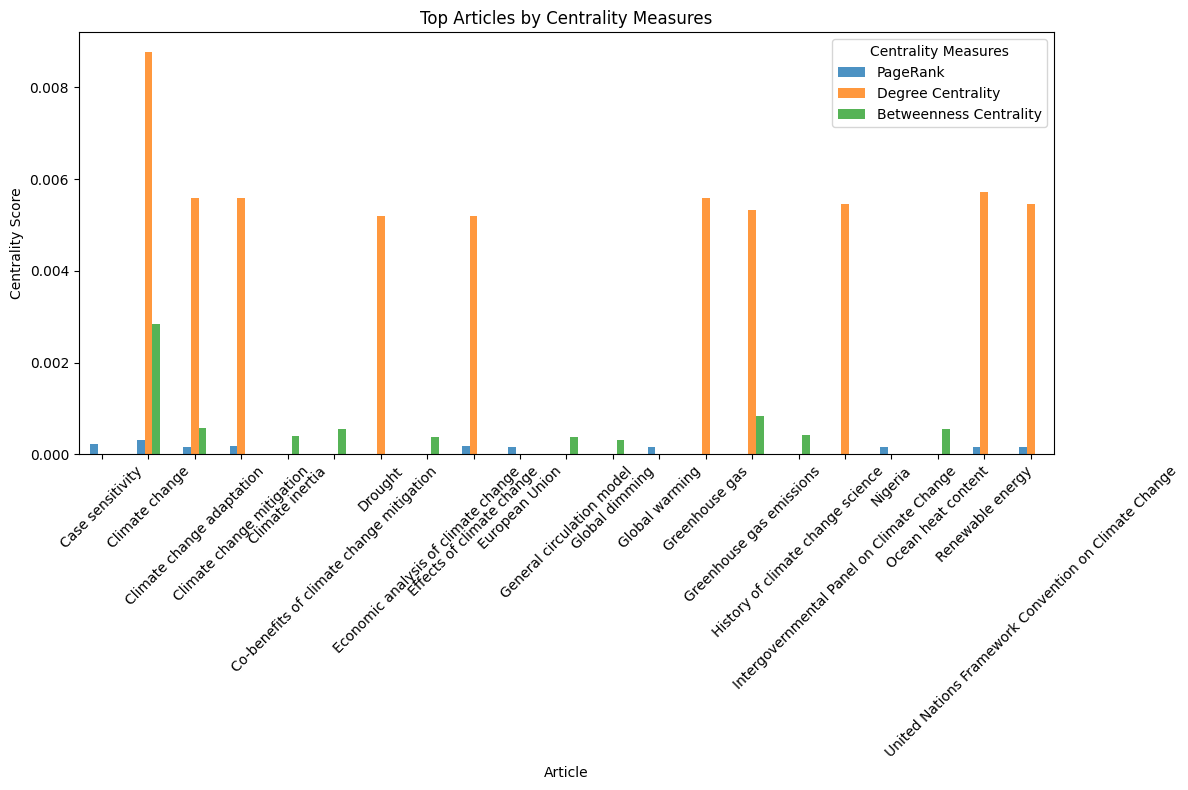

In [30]:
# Step 6: Prepare data for visualization
top_n = 10  # Define how many top nodes to show

# Create DataFrames for each centrality measure
pagerank_df = pd.DataFrame(list(pagerank.items()), columns=['Article', 'PageRank']).nlargest(top_n, 'PageRank')
degree_centrality_df = pd.DataFrame(list(degree_centrality.items()), columns=['Article', 'Degree Centrality']).nlargest(top_n, 'Degree Centrality')
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Article', 'Betweenness Centrality']).nlargest(top_n, 'Betweenness Centrality')

# Merge the data into a single DataFrame, keeping track of articles that exist in multiple measures
combined_df = pd.merge(pagerank_df, degree_centrality_df, on='Article', how='outer')
combined_df = pd.merge(combined_df, betweenness_df, on='Article', how='outer')

# Fill NaN values with 0 for missing articles
combined_df.fillna(0, inplace=True)

# Set the article names as the index
combined_df.set_index('Article', inplace=True)

# Step 7: Plotting
combined_df.plot(kind='bar', figsize=(12, 8), alpha=0.8)
plt.title('Top Articles by Centrality Measures')
plt.ylabel('Centrality Score')
plt.xticks(rotation=45)
plt.legend(title='Centrality Measures')
plt.tight_layout()
plt.show()